<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">22.418 · Aprenentatge automàtic</p>
<p style="margin: 0; text-align:right;">Grau en Ciència de Dades Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Recurrent Neural Networks for time series analysis (TSA)

In this notetbook we will work with recurrent neural networks in a regression problem with synthetically generated data.

Time series analysis is different than the regression tasks we have seen in previous notebooks. Time-series forecast is an extrapolation task while the regression tasks we have seen before are intrapolations. Time-series refers to an ordered series of data in time, and time-series models are used to forecast what comes next in the series by using some previous (ordered) observations. Typical time-series applications include weather forecasting, stock prices forecasting, etc.

At the beginning of this example we will see how to generate data synthetically for a time series.

Next, we will decomopose the series into its trend and seasonality components:
- Seasonal variation, or seasonality, are cycles that repeat regularly over time. 
- Trend is the ooverall increasing or decreasing value in the series. 

Finally, with the standardized data, we will train several models that will allow to predict the future values of the series.

"**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/), you should install the dependencies by running the following cell:

In [3]:
! pip install scikit-learn matplotlib tensorflow numpy statsmodels==0.12.1

### Load the necessary libraries

The following code imports the packages needed for this example.

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

### Synthetically generate the data

In this example we will work with a time series generated synthetically using `numpy`.

The following code generates a time series with some randomness, saves the series in the variable `series` and shows it in a plot.

We generate the series by the addition of a parabola and a sine.

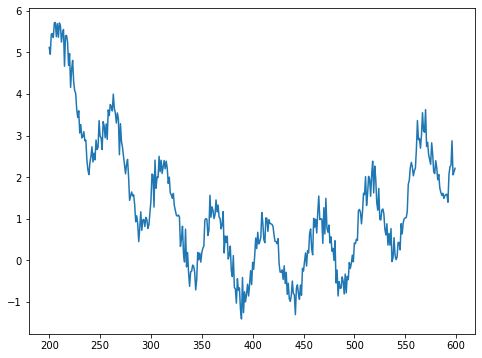

In [5]:
# function  to generate the time series
def f(x):
    return np.square(-x+425)/10000 + np.sin(x/8) + 0.25*np.random.randn()

idx = np.arange(200, 600)
serie = np.array([f(x) for x in idx])

plt.rc("figure", figsize=(8,6))
plt.plot(idx, serie)


### Extract the trend and seasonality components

For the neural network to be able to find patterns in the time series it is necessary to transform the series so that the values are always in the same range. To do this, we can extract/remove the **trend** and **seasonality** of the series and undo the changes at the time of obtaining new predictions.

For this we will need to find first the **periodicity** of the sequence. In this example case, since we have generated the data synthetically, we can calculate the exact periodicity through the data generation formula. Since the sine is a periodic function of period $2 * \pi$, the period of the series will be that value of $x$ such that $x / 8 = 2 * \pi$, which rounded to an integer is 50.

Next, we will proceed to extract the trend and seasonality empirically using the `STL` class of the `statsmodels` library and draw it with the `plot` method of the same library.

[statsmodels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. 

[`statsmodels.tsa.seasonal.STL`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL): Season-Trend decomposition using LOESS (locally estimated scatterplot smoothing), a local regression non-parametric method. 

- Parameters: 
    - endog (array_like): Data to be decomposed. 
    - period ({int, None}): Periodicity of the sequence. If endog is a ndarray, period must be provided.
    - ...
- Methods:
    - fit(): Estimate season, trend and residuals components.

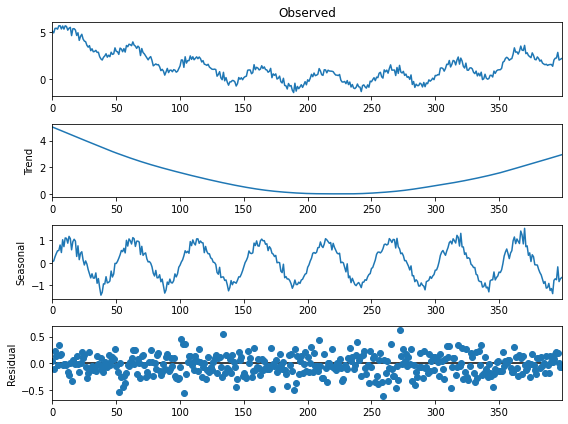

In [6]:
# season-trend descomposition for the correct period value
decomp = STL(serie,period=50).fit()
decomp.plot()
plt.show()

We will now proceed to repeat the trend and seasonality extraction using **different values for the period**, in order to see the relevance of determining the period in the trend and seasonality extraction when it is unknown. We will test with multiple values and divisors of the period, as well as with other random values.

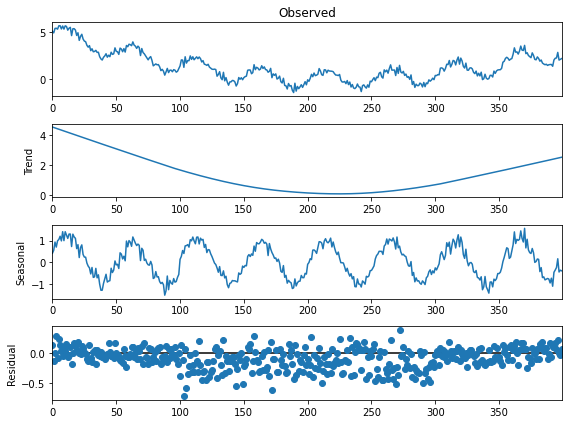

In [7]:
decomp_100 = STL(serie, period=100).fit()
decomp_100.plot()
plt.show()

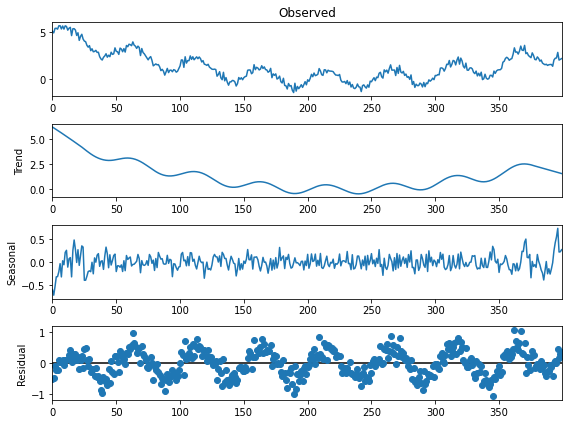

In [8]:
decomp_25 = STL(serie, period=25).fit()
decomp_25.plot()
plt.show()

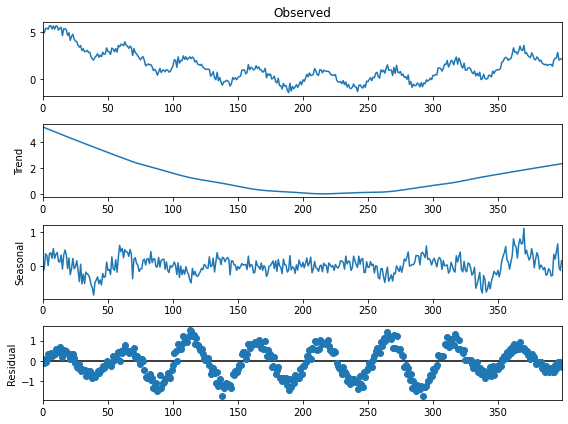

In [9]:
decomp_75 = STL(serie, period=75).fit()
decomp_75.plot()
plt.show()

From the above examples and the importance of correctly calculating the seasonal period of a time series, we appreciate that:

- When a **multiple of the correct period** is used, the decomposition is correct.
- When **other values** are used, the decomposition completely loses its meaning.

There are many other methods to remove the trend and seasonality of a series.

One simple alternative is to transform the series by taking $i[t] = x[t] - x[t-1]$. In this case, the main differences with the STL approach seen are as follows:

- It can be used in any case and it is not necessary to find out the period.
- The "memory" of the network is lost, as the value $i[t]$ only depends on the values in the series at $t-1$ and $t$.

### Predicting the trend

Normally the trend of a time series changes slowly over time. In addition, at the time of making predictions it usually takes (future) input values out of the range in the training data. This forces the model to extrapolate, so we need very robust models to predict the trend.

Here we will train a polynomial model with the variables $x$ and $x^2$ as input to predict the values of the trend in the training set, using the `LinearRegression` class of `sklearn`.

In [10]:
# Data pre-processing and model training
features = np.hstack([idx.reshape(-1, 1), np.square(idx.reshape(-1, 1))])
reg = LinearRegression().fit(features, decomp.trend)

The following code compares in a plot the original trend and its prediction with tthe linear regression model.

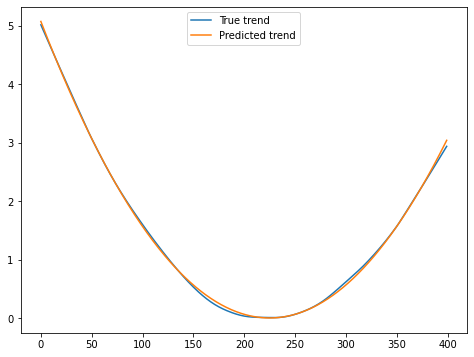

In [11]:
# show the predicted and true trend
plt.rc("figure", figsize=(8,6))
plt.plot(decomp.trend, label="True trend")
plt.plot(reg.predict(features), label="Predicted trend")
plt.legend(loc="upper center")
plt.show()

### Predicting  the seasonal component

When we decompose the time series we obtain the seasonality as a new time series that is repeated over time, so it is very suitable to be predicted using a recurrent neural network (RNN).

Since neural networks repeatedly perform the same operation on a data set, it is important to normalize the values of the series to avoid problems of vanishing and exploding gradients.

The following code normalizes the values of the seasonal series to values between 0 and 1.

In [12]:
# Data normalization
scaler = MinMaxScaler(feature_range = (0, 1))
scaler_season = scaler.fit(decomp.seasonal.reshape(-1, 1))
seasonal_norm = scaler_season.transform(decomp.seasonal.reshape(-1, 1))

The following code generates the training dataset for the RNN. 

Using `lookback = 30` each example in the training set contains the last 30 values in the series and its label corresponds to the next value.

In [13]:
lookback = 30

features_set = [] 
labels = []  
for i in range(lookback, seasonal_norm.shape[0]):  
    features_set.append(seasonal_norm[i-lookback:i, 0])
    labels.append(seasonal_norm[i, 0])

features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

Next, we will proceed to define and train a recurrent neural network (RNN) with the following characteristics:

- A recurring layer with **GRU cells**
- A **fully connected (FC)** layer with a single output neuron (the prediction), with a **linear activation** function.

The model will  be trained using the `Adam` optimizer and the Mean Squared Error loss function.

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(units=50, input_shape=(features_set.shape[1], 1)))
model.add(tf.keras.layers.Dense(units = 1))
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [15]:
# train the model
history = model.fit(features_set, labels, epochs = 25, batch_size = 32, verbose=0, validation_split=0.1)

Visualize the loss curve:

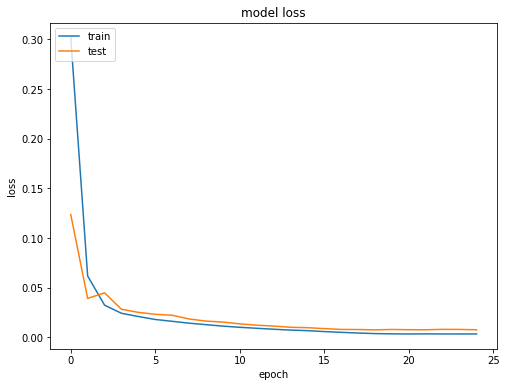

In [16]:
# Visualize the loss evolution during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We will then use the previously trained model to predict the values of the seasonal series training set and plot them.

In [17]:
# predicting the seasonal component
train_pred = model.predict(features_set)

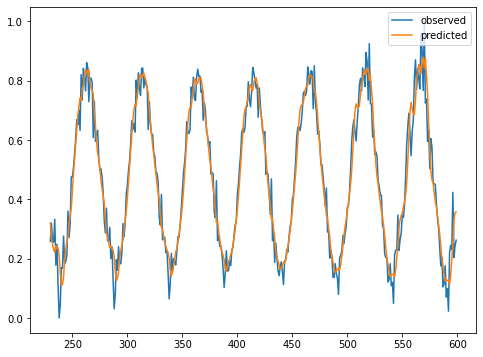

In [18]:
# Plot the true (observed) and predicted series
plt.rc("figure", figsize=(8,6))
plt.plot(idx[lookback:], seasonal_norm[lookback:], label="observed")
plt.plot(idx[lookback:], train_pred, label="predicted")
plt.legend(loc="upper right")
plt.show()

### Predicting the complete series 

To predict new values from the original series it is necessary to calculate the predictions of the two models (trend and seasonal), undo the normalization of the neural network and add the two predictions.

In [19]:
# Combined predictions
train_pred = np.add(scaler_season.inverse_transform(train_pred).reshape(-1), reg.predict(features[lookback:]))

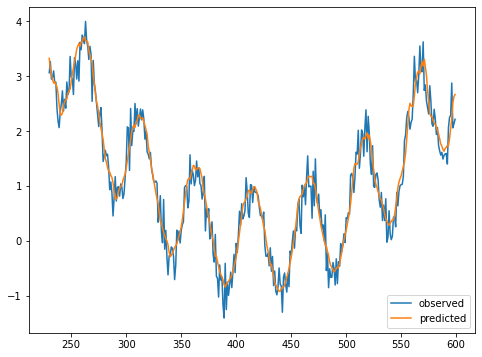

In [20]:
# Plott observed vs. predicted series
plt.rc("figure", figsize=(8,6))
plt.plot(idx[lookback:], serie[lookback:], label="observed")
plt.plot(idx[lookback:], train_pred, label="predicted")
plt.legend(loc="lower right")
plt.show()

### Predicting future values

Let's see how our combined model performs at predictiing future values. Foor this we need first to generate some new future values using our data generator function:

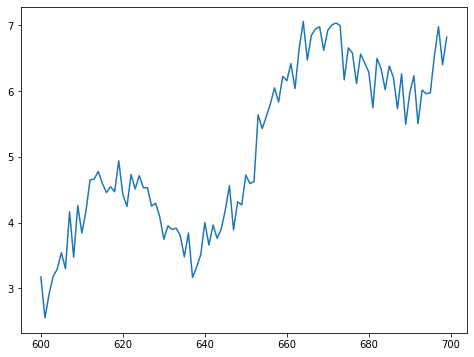

In [21]:
# Generate and plot new values for the series
idx_new = np.arange(600, 700)
serie_new = [f(x) for x in idx_new]

plt.rc("figure", figsize=(8,6))
plt.plot(idx_new, serie_new)
plt.show()

We will use the previously trained polynomial model to calculate the trend prediction for the new values of the series.

In [22]:
# Trend prediction
features_new = np.hstack([idx_new.reshape(-1, 1), np.square(idx_new.reshape(-1, 1))])
pred_tendencia = reg.predict(features_new)

The following code predicts seasonal values one at a time using a window of 30 prior values. Nootice that we **use the predicted values as input** to predict future values in the series.

In [23]:
pre_data = seasonal_norm[-lookback:]
reg_orig = np.array(pre_data)

test_preds = []
for i in idx_new:
    reg_lstm = np.reshape(reg_orig, (1, reg_orig.shape[0], 1))
    test_pred = model.predict(reg_lstm)
    test_preds.append(test_pred)
    reg_orig = np.roll(reg_orig, -1)
    reg_orig[-1] = test_pred

test_preds = np.array(test_preds).reshape(-1, 1)

Finally, we can aggregate the predictions of the two models for the new values and show them in a plot.

In [24]:
test_pred = np.add(scaler_season.inverse_transform(test_preds).reshape(-1), pred_tendencia)

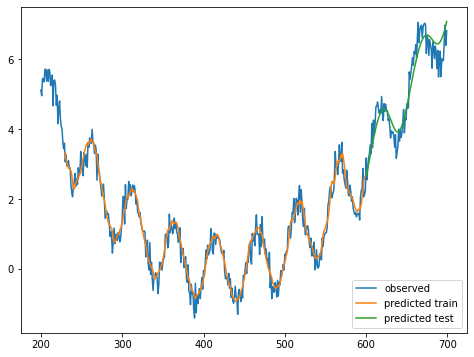

In [25]:
idx_global = np.arange(200, 700)
obs = np.hstack([serie, serie_new])

plt.rc("figure", figsize=(8,6))
plt.plot(idx_global, obs, label="observed")
plt.plot(idx[lookback:], train_pred, label="predicted train")
plt.plot(idx_new, test_pred, label="predicted test")
plt.legend(loc="lower right")
plt.show()